# Bipedal Walker Solution with Proximal Policy Optimisation

This program runs two Actor Critic agents with PPO on OpenAI Gym's Bipedal Walker environment. Each agent pertains to a different configuration outlined in the report.

### Setup

First, we import all the necessary libraries that will be used in the program. We use torch for neural network operations, numpy for array manipulation e.g. replay memory, and gym to initialise and step through the environment. We also import MultivariateNormal from torch for action selection.

In [1]:
#PyTorch for neural network construction
import torch as T
import torch.nn as nn
#MultivariateNormal for action selection
from torch.distributions import MultivariateNormal
#Gym to initialise and step through environment
import gym
#NumPy for array operations e.g. replay memory modification
import numpy as np

### Actor Critic Initialisation

In this code block, we architect the Actor and Critic models for the Agent to use. In the class, we also include the actorForward() function, which passes the state into the Actor, which outputs the means over the actions the agents can take. These means are then used with the standard deviation to construct the Normal Distribution curve to sample actions from.

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, state_space, action_space, action_std, ac_func):
        super(ActorCritic, self).__init__()
        #Actor model selects action to take by outputting means over all actions
        self.actor =  nn.Sequential(
                nn.Linear(state_space, 128),
                ac_func,
                nn.Linear(128, 64),
                ac_func,
                nn.Linear(64, 32),
                ac_func,
                nn.Linear(32, action_space),
                ac_func
                )
        #Critic evaluates Actor actions by outputting Q-value
        self.critic = nn.Sequential(
                nn.Linear(state_space, 64),
                ac_func,
                nn.Linear(64, 32),
                ac_func,
                nn.Linear(32, 1)
                )
        
        self.action_var = T.full((action_space,), action_std*action_std)
        
    #Forward pass through Actor network creates a Normal Distribution over potential actions and returns it.
    def actorForward(self, state, evaluate):
        action_mean = self.actor(state)
        
        if evaluate:
            cov_mat = T.diag_embed(self.action_var.expand_as(action_mean))
        else:    
            cov_mat = T.diag(self.action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        return dist

### Agent Initialisation

This code block represents the structure of the Agent. In this class we:
- Initialise the networks, hyperparameters, and replay memory
- Have the select_action() function which is used to sample the action from the distribution created in the actorForward function.
- Store the experience of the agent after every timestep in store_transition()
- Have the update() function which discounts and standardises the rewards before calculating the ratios between the new and old policy
- Have the optimise() function which calculates the losses of the Actor and Critic before performing back propagation


In [3]:
class Agent:
    def __init__(self, state_space, action_space, action_std, lr, gamma, K_epochs, eps_clip, ac_func):
        self.lr = lr                                #Learning rate
        self.gamma = gamma                          #Discount factor
        self.eps_clip = eps_clip                    #Clipping value for PPO
        self.K_epochs = K_epochs                    #No. of epochs to optimise agent
        self.state_space = state_space              #State space of environment
        self.action_space = action_space            #Action space of environment
        self.replay_mem_size = 2000                 #Size of memory to store agent experiences
        self.mem_index = 0                          #Index to track current memory size
        self.ac_func = ac_func                      #Chosen activation function between neural network layers
        
        
        #Represents the current policy
        self.target_policy = ActorCritic(self.state_space, self.action_space, action_std, self.ac_func)
        self.optimizer = T.optim.Adam(self.target_policy.parameters(), lr=lr)
        
        #Represents the old policy
        self.old_policy = ActorCritic(self.state_space, self.action_space, action_std, self.ac_func)
        self.old_policy.load_state_dict(self.target_policy.state_dict())
        
        #Loss function
        self.loss_func = nn.MSELoss()
        
        #Replay memory stores states, actions, rewards, log probabilities of actions, and whether the action was terminal
        self.state_memory = np.zeros((self.replay_mem_size, self.state_space), dtype=np.float32)
        self.action_memory = np.zeros((self.replay_mem_size, self.action_space), dtype=np.float32)
        self.reward_memory = np.zeros(self.replay_mem_size, dtype=np.float32)
        self.logprobs_memory = np.zeros(self.replay_mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.replay_mem_size, dtype=np.float32)
        
        #Store actor and critic losses over time
        self.actor_losses = []
        self.critic_losses = []
    
    def select_action(self, state):
        #State must be converted to tensor before passing into Actor
        state = T.FloatTensor(state.reshape(1, -1))
        
        #Create Normal Distribution based on action means generated by Actor and Standard deviation
        dist = self.old_policy.actorForward(state, False)
        
        #Sample action and log probability of action
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action, state, action_logprob
    
    #After each timestep, store the experience into replay memory
    def store_transition(self, state, action, logprob, reward, done):
        index = self.mem_index % self.replay_mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.logprobs_memory[index] = logprob
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        
        self.mem_index += 1
    
    def optimize(self, rewards, state_values, dist_entropy, ratios):
        #Calculate advantage to determine how good the action taken is
        advantages = rewards - state_values.detach()
        
        #Critic discount * loss function to determine overall loss for Critic
        critic_loss = 0.5*self.loss_func(state_values, rewards)
        self.critic_losses.append(critic_loss.item())
        
        #Calculate Actor loss in accordance to PPO clip equation: #https://openai.com/blog/openai-baselines-ppo/
        actor_loss = -T.min(ratios * advantages, T.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages)
        self.actor_losses.append(actor_loss.mean())

        #Combine losses and subtract entropy to promote exploration
        loss = critic_loss + actor_loss - dist_entropy
        
        #Perform back propagation and optimise weights
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
    
    def update(self):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.reward_memory), reversed(self.terminal_memory)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            

        #Standardising the rewards:
        rewards = T.tensor(rewards, dtype=T.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        #Convert numpy array to tensor before passing into network
        state_memory = T.tensor(self.state_memory)
        action_memory = T.tensor(self.action_memory)
        logprobs_memory = T.tensor(self.logprobs_memory)

        #Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            #Obtain distribution of actions over current policy
            dist = self.target_policy.actorForward(state_memory, True)

            action_logprobs = dist.log_prob(action_memory)
            dist_entropy = dist.entropy()
            
            #Determine Critic q-value to optimise agent
            state_value = T.squeeze(self.target_policy.critic(state_memory))

            #Finding the ratio between actions over current policy against old policy
            ratios = T.exp(action_logprobs - logprobs_memory.detach())

            self.optimize(rewards, state_value, dist_entropy, ratios)

        #Copy new weights into old policy:
        self.old_policy.load_state_dict(self.target_policy.state_dict())

### Setup

In this code block we define the hyperparameters and initialise the agents and environment. In this file we have included the agents from both configurations outlined in the report. 

In [4]:
max_episodes = 300          #Max episodes to train the agent

update_timestep = 2000      #Frequency of policy update
action_std = 0.5            #Constant std for normal distribution
K_epochs = 80               #How many epochs to update the policy
eps_clip = 0.2              #How much to clip the policy update by
gamma = 0.99                #Discount factor

lr = 0.0003                 #Learning rate for Adam optimiser

#Initialising environment
env = gym.make("BipedalWalker-v3")
state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

OptimalAgent = Agent(state_space, action_space, action_std, lr, gamma, K_epochs, eps_clip, nn.Tanh()) #Configuration 2 Agent (From report)

Config1Agent = Agent(state_space, action_space, 0.5, 0.05, 0.99, K_epochs, 0.2, nn.ReLU()) #Configuration 1 Agent (From report)

/Users/kamranshamsi/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Main Loop

To analyse a single agent's performance, simply comment out either Line 36 or Line 38 of this code block depending on the desired agent to be run. We also define the main loop of the agent which:
- Selects an action to take in the environment
- Executes the action
- Adds the reward gained to the total running score of the episode
- Stores the experience
- Updates the agent if the specified time has passed (by the update_timestep parameter)
- Logs the reward of the agent every 20 episodes to track learning

This process is repeated for each episode that the agent runs for (and will run for each agent initialised).

In [5]:
#Training loop
def rollout(agent):
    time_step = 0
    ep_reward = []
    for i_ep in range(max_episodes):
        state = env.reset()
        score = 0
        done = False
        while not done:
            time_step +=1
            # Running old_policy:
            action, stateAdd, action_logprob = agent.select_action(state)
            actionTaken = action.detach().data.numpy().flatten()
            state, reward, done, _ = env.step(actionTaken)
            score += reward

            #Store transition for replay memory:
            agent.store_transition(stateAdd, action, action_logprob, reward, done)

            #Update if its time
            if time_step % update_timestep == 0:
                agent.update()
                time_step = 0

            if done:
                break
        if i_ep % 20 == 0:
            print("Episode: ", i_ep, "Score: ", "%.3f" % score)
        ep_reward.append(score)
    
    return ep_reward
    
print("Running Agent 1")    
Config1Reward = rollout(Config1Agent)
print("Running Agent 2") 
Config2Reward = rollout(OptimalAgent)

Running Agent 1
Episode:  0 Score:  -60.016
Episode:  20 Score:  -56.843
Episode:  40 Score:  -57.541
Episode:  60 Score:  -97.898
Episode:  80 Score:  -113.865
Episode:  100 Score:  -57.123
Episode:  120 Score:  -122.006
Episode:  140 Score:  -110.661
Episode:  160 Score:  -65.854
Episode:  180 Score:  -97.723
Episode:  200 Score:  -101.129
Episode:  220 Score:  -116.847
Episode:  240 Score:  -101.695
Episode:  260 Score:  -98.757
Episode:  280 Score:  -97.921
Running Agent 2
Episode:  0 Score:  -120.468
Episode:  20 Score:  -98.524
Episode:  40 Score:  -117.250
Episode:  60 Score:  -83.710
Episode:  80 Score:  -66.512
Episode:  100 Score:  -62.844
Episode:  120 Score:  -122.025
Episode:  140 Score:  -67.227
Episode:  160 Score:  -68.498
Episode:  180 Score:  -53.264
Episode:  200 Score:  -5.417
Episode:  220 Score:  35.096
Episode:  240 Score:  46.269
Episode:  260 Score:  64.077
Episode:  280 Score:  72.001


### Configuration 1 Results

Plotting:
- Episode against total reward
- Actor losses
- Critic losses

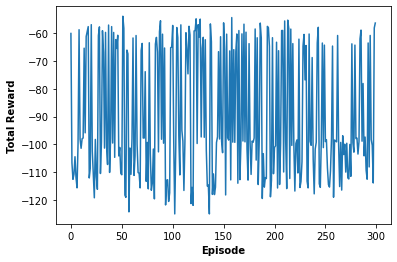

In [6]:
import matplotlib.pyplot as plt

plt.plot(Config1Reward)
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.show()

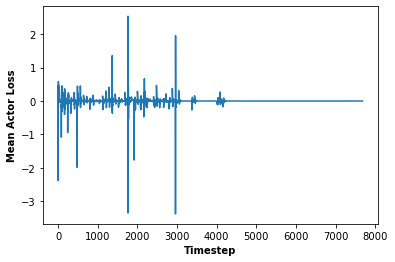

In [7]:
plt.plot(Config1Agent.actor_losses)
plt.xlabel("Timestep", fontweight="bold")
plt.ylabel("Mean Actor Loss", fontweight="bold")
plt.show()

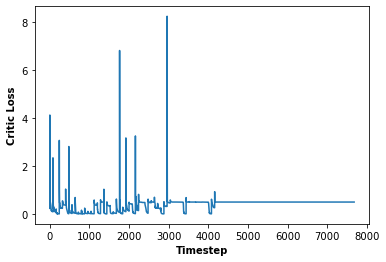

In [8]:
plt.plot(Config1Agent.critic_losses)
plt.xlabel("Timestep", fontweight="bold")
plt.ylabel("Critic Loss", fontweight="bold")
plt.show()

### Configuration 2 Results

Plotting:
- Episode against total reward
- Actor losses
- Critic losses

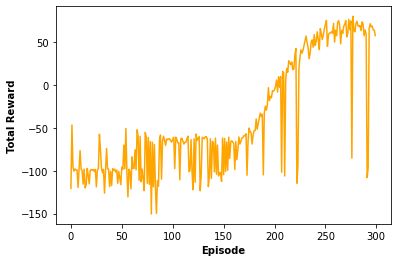

In [16]:
plt.plot(Config2Reward, color="orange")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.show()

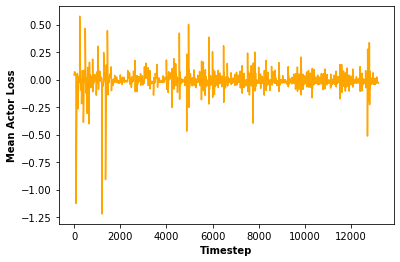

In [17]:
plt.plot(OptimalAgent.actor_losses, color="orange")
plt.xlabel("Timestep", fontweight="bold")
plt.ylabel("Mean Actor Loss", fontweight="bold")
plt.show()

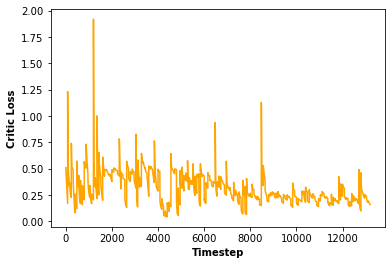

In [18]:
plt.plot(OptimalAgent.critic_losses, color="orange")
plt.xlabel("Timestep", fontweight="bold")
plt.ylabel("Critic Loss", fontweight="bold")
plt.show()

### Configurations Compared

Plot the two configurations against eachother for analysis in the report attached

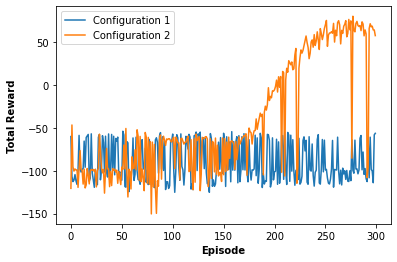

In [12]:
plt.plot(Config1Reward, label="Configuration 1")
plt.plot(Config2Reward, label="Configuration 2")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.legend()
plt.show()

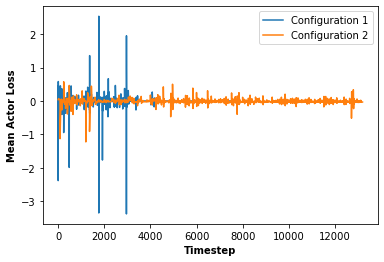

In [13]:
plt.plot(Config1Agent.actor_losses, label="Configuration 1")
plt.plot(OptimalAgent.actor_losses, label="Configuration 2")
plt.xlabel("Timestep", fontweight="bold")
plt.ylabel("Mean Actor Loss", fontweight="bold")
plt.legend()
plt.show()

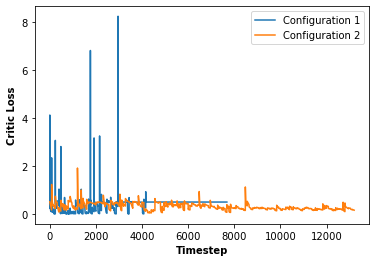

In [14]:
plt.plot(Config1Agent.critic_losses, label="Configuration 1")
plt.plot(OptimalAgent.critic_losses, label="Configuration 2")
plt.xlabel("Timestep", fontweight="bold")
plt.ylabel("Critic Loss", fontweight="bold")
plt.legend()
plt.show()